In [ ]:
"""
this pipeline needs to be able to detect if a person is horizontal and if so is the persons head facing to the left or right vertically

based on that observation we can make the decision which value we should choose for detecting the face

1. input the image and then return in prompt if horizontal and if so if left or right facing

2. extract result from prompt 

3. based on result return the value 0 or 90 or 270
"""

In [ ]:
!pip install litellm python-dotenv opencv-python

In [31]:
import os
import cv2
from litellm import completion
import base64
from dotenv import load_dotenv
import json

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [110]:
#define image path
image_path = "examples/4.jpeg"

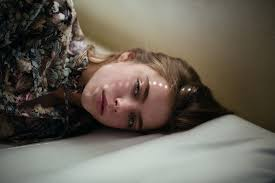

In [111]:
from IPython.display import Image, display

# Display the image
display(Image(image_path))

In [112]:
def get_alignment_of_faces(vision_frame) -> str:
	#!only temporarly for testing in prod the vision frame will be no path
	vision_frame = cv2.imread(vision_frame)

	# Convert frame to PNG in memory and encode to base64
	_, buffer = cv2.imencode('.png', vision_frame)
	base64_image = base64.b64encode(buffer).decode('utf-8')

	prompt="""
	You are analyzing an image of a person lying horizontally. Your task is to determine the rotation angle:

	- Classify as 90 DEGREES if: The person is lying with their head to the RIGHT side of the image (meaning the top/crown of their head points right)
	- Classify as 270 DEGREES if: The person is lying with their head to the LEFT side of the image (meaning the top/crown of their head points left)
	- Classify as 0 DEGREES if: The person is not lying horizontally or you cannot clearly determine orientation

	Important: Focus strictly on which direction the TOP of the head is pointing, not where the face is looking. Imagine the head as an arrow - the pointed end (top/crown of head) determines the direction.

	For reference:
	- In 90° rotation, the top of the head points RIGHT when viewed from above
	- In 270° rotation, the top of the head points LEFT when viewed from above

	Provide your classification and a brief explanation.
	"""

	# Make API call to vision model
	response = completion(
		model="gpt-4o-mini",
		messages=[
			{
				"role": "user",
				"content": [
					{
						"type": "text",
						"text": prompt
					},
					{
						"type": "image_url",
						"image_url": {
							"url": f"data:image/jpeg;base64,{base64_image}"
						}
					}
				]
			}
		],
	)
	return response.choices[0].message.content

In [113]:
value=get_alignment_of_faces(image_path)

In [114]:
print(value)

Based on the criteria provided, I classify the orientation as **270 DEGREES**. 

The reasoning is that the top or crown of the person's head is pointing to the left side of the image when viewed from above. This aligns with the definition for a 270-degree classification.


In [115]:
#extract the result from the response
def extract_result(response: str) -> str:
	"""
	this function should extract horizontal left - 90 or right - 270 or nothing - 0
	"""
	prompt = f"""
	You are processing the output from an image orientation detection system. Extract ONLY the orientation value based on these rules:
	- If the detection result indicates a person lying horizontally with head oriented LEFT: return 90
	- If the detection result indicates a person lying horizontally with head oriented RIGHT: return 270
	- For any other case (vertical orientation, unclear result, no person detected, or ambiguous response etc.): return 0

	Here is the detection result to analyze:

	{response}

	Respond with ONLY a JSON object containing a single key "value" with value 90, 270, or 0.
	"""
	response = completion(
    	model = "gpt-4o", 
		response_format={ "type": "json_object" },
    	messages=[{ "content": prompt,"role": "user"}],
		temperature=0.0
	)
	response_json = json.loads(response.choices[0].message.content)
	#how to make sure that the model really only responds with one value ie 90 or 270 or 0?
	return response_json["value"]

In [116]:
final_value=extract_result(value)

In [117]:
print(final_value)

0
